### Installing KGCNN





In [26]:
!pip install kgcnn==0.1.0
!pip install openbabel==3.0.0a1

### Necessary imports

In [27]:
import math
import numpy as np
import tensorflow as tf
import tensorflow.keras as ks
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from kgcnn.data.qm.qm9 import qm9_graph
from kgcnn.literature.Megnet import getmodelMegnet,softplus2
from kgcnn.utils.learning import lr_lin_reduction

# BRIEF INTRODUCTION TO `RaggedTensor`

*Ragged tensors* are the TensorFlow equivalent of nested variable-length
lists. They make it easy to store and process data with non-uniform shapes,
including:

*   Variable-length features, such as the set of actors in a movie.
*   Batches of variable-length sequential inputs, such as sentences or video
    clips.
*   Hierarchical inputs, such as text documents that are subdivided into
    sections, paragraphs, sentences, and words.
*   Individual fields in structured inputs, such as protocol buffers.


### Constructing a ragged tensor

The simplest way to construct a ragged tensor is using
`tf.ragged.constant`, which builds the
`RaggedTensor` corresponding to a given nested Python `list` or numpy `array`

In [28]:
sentences = tf.ragged.constant([
    ["Let's", "build", "some", "ragged", "tensors", "!"],
    ["We", "can", "use", "tf.ragged.constant", "."]])
print(sentences)

<tf.RaggedTensor [[b"Let's", b'build', b'some', b'ragged', b'tensors', b'!'],
 [b'We', b'can', b'use', b'tf.ragged.constant', b'.']]>


In [29]:
paragraphs = tf.ragged.constant([
    [['I', 'have', 'a', 'cat'], ['His', 'name', 'is', 'Mat']],
    [['Do', 'you', 'want', 'to', 'come', 'visit'], ["I'm", 'free', 'tomorrow']],
])
print(paragraphs)

<tf.RaggedTensor [[[b'I', b'have', b'a', b'cat'], [b'His', b'name', b'is', b'Mat']],
 [[b'Do', b'you', b'want', b'to', b'come', b'visit'],
  [b"I'm", b'free', b'tomorrow']]]>


Ragged tensors can also be constructed by pairing flat *values* tensors with
*row-partitioning* tensors indicating how those values should be divided into
rows, using factory classmethods such as `tf.RaggedTensor.from_value_rowids`,
`tf.RaggedTensor.from_row_lengths`, and
`tf.RaggedTensor.from_row_splits`. View the [docs](https://www.tensorflow.org/api_docs/python/tf/RaggedTensor) to see how.

## Ragged vs. sparse

A ragged tensor should *not* be thought of as a type of sparse tensor.  In particular, sparse tensors are *efficient encodings for tf.Tensor*, that model the same data in a compact format; but ragged tensor is an *extension to tf.Tensor*, that models an expanded class of data.  This difference is crucial when defining operations:

* Applying an op to a sparse or dense tensor should always give the same result.
* Applying an op to a ragged or sparse tensor may give different results.


![ragged_concat](https://www.tensorflow.org/images/ragged_tensors/ragged_concat.png)


In [30]:
ragged_x = tf.ragged.constant([["John"], ["a", "big", "dog"], ["my", "cat"]])
ragged_y = tf.ragged.constant([["fell", "asleep"], ["barked"], ["is", "fuzzy"]])
print(tf.concat([ragged_x, ragged_y], axis=1))

<tf.RaggedTensor [[b'John', b'fell', b'asleep'], [b'a', b'big', b'dog', b'barked'],
 [b'my', b'cat', b'is', b'fuzzy']]>


But concatenating sparse tensors is equivalent to concatenating the corresponding dense tensors,
as illustrated by the following example (where Ø indicates missing values):

![sparse_concat](https://www.tensorflow.org/images/ragged_tensors/sparse_concat.png)


In [31]:
sparse_x = ragged_x.to_sparse()
sparse_y = ragged_y.to_sparse()
sparse_result = tf.sparse.concat(sp_inputs=[sparse_x, sparse_y], axis=1)
print(tf.sparse.to_dense(sparse_result, ''))

tf.Tensor(
[[b'John' b'' b'' b'fell' b'asleep']
 [b'a' b'big' b'dog' b'barked' b'']
 [b'my' b'cat' b'' b'is' b'fuzzy']], shape=(3, 5), dtype=string)


## IMPLEMENTING MEGNet NETWORKS USING KCGNN

In [32]:
# Download Dataset
qm9_data = qm9_graph()
y_data = qm9_data[0][:,7]*27.2114  #select LUMO in eV
x_data = qm9_data[1:]

#Scale output
y_mean = np.mean(y_data)
y_data = (np.expand_dims(y_data,axis=-1)-y_mean)  
data_unit = 'eV'

Database path: C:\Users\LAMSD\my_app\Lib\site-packages\kgcnn\data\qm
Creating directory ... done
Read Zip File ... done
Extracting Zip folder...done
Reading dsgdb9nsd files ...done
Saving qm9.pickle ...done
Clean up unzipped folder...done
Making graph ...done


In [33]:
#Make test/train split
VALSIZE = 100
TRAINSIZE = 2000
print("Training Size:",TRAINSIZE," Validation Size:",VALSIZE )
inds = np.arange(len(y_data))
inds = shuffle(inds)
ind_val = inds[:VALSIZE ]
ind_train = inds[VALSIZE:(VALSIZE + TRAINSIZE)]

# Select train/test data
xtrain = [[x[i] for i in ind_train] for x in x_data]
ytrain = y_data[ind_train]
xval = [[x[i] for i in ind_val] for x in x_data]
yval = y_data[ind_val]

Training Size: 2000  Validation Size: 100


In [34]:
def make_ragged(inlist):
    return tf.RaggedTensor.from_row_lengths(np.concatenate(inlist,axis=0), np.array([len(x) for x in inlist],dtype=np.int))

#Make ragged graph tensors plus normal tensor for graph state
xval = [make_ragged(x) for x in xval[:3]] + [tf.constant(xval[3])]
xtrain = [make_ragged(x) for x in xtrain[:3]] + [tf.constant(xtrain[3])]


C:\Users\LAMSD\AppData\Local\Temp/ipykernel_11884/2669346059.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return tf.RaggedTensor.from_row_lengths(np.concatenate(inlist,axis=0), np.array([len(x) for x in inlist],dtype=np.int))


In [35]:
model =  getmodelMegnet(
                    # Input
                    input_node_shape = [None],
                    input_edge_shape = [None,20],
                    input_state_shape = [1],
                    input_node_vocab = 10,
                    input_node_embedd = 16,
                    input_edge_embedd = 16,
                    input_type = 'ragged', 
                    # Output
                    output_embedd = 'graph', #Only graph possible for megnet
                    output_use_bias = [True,True,True],
                    output_dim = [32,16,1],
                    output_activation = ['softplus2','softplus2','linear'],
                    output_type = 'padded',
                    #Model specs
                    is_sorted = True,
                    has_unconnected = False,
                    nblocks = 3,
                    n1= 64,
                    n2 = 32,
                    n3= 16,
                    set2set_dim = 16,
                    use_bias = True,
                    act = 'softplus2',
                    l2_coef = None,
                    has_ff = True,
                    dropout = None,
                    dropout_on_predict = False,
                    use_set2set = True,
                    npass= 3,
                    set2set_init = '0',
                    set2set_pool = "sum"
                    )


learning_rate_start = 0.5e-3
learning_rate_stop = 1e-5
epo = 500
epomin = 400
optimizer = tf.keras.optimizers.Adam(lr=learning_rate_start)

cbks = tf.keras.callbacks.LearningRateScheduler(lr_lin_reduction(learning_rate_start,learning_rate_stop,epomin,epo))
model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mean_absolute_error', 'mean_squared_error'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node_input (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 node_embedding (Embedding)     (None, None, 16)     160         ['node_input[0][0]']             
                                                                                                  
 edge_input (InputLayer)        [(None, None, 20)]   0           []                               
                                                                                                  
 edge_index_input (InputLayer)  [(None, None, 2)]    0           []                               
                                                                                              

C:\Users\LAMSD\my_app\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
trainlossall = []
testlossall = []
validlossall = []

epostep = 10

hist = model.fit(xtrain, ytrain, 
          epochs=epo,
          batch_size=64,
          callbacks=[cbks],
          validation_freq=epostep,
          validation_data=(xval,yval),
          verbose=2
          )

trainlossall = hist.history['mean_absolute_error']
testlossall = hist.history['val_mean_absolute_error']


trainlossall =np.array(trainlossall)
testlossall = np.array(testlossall)

mae_valid = np.mean(np.abs(yval-model.predict(xval)))

Epoch 1/500


C:\Users\LAMSD\my_app\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/megnet_2/gather_nodes_2/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model/megnet_2/gather_nodes_2/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/model/megnet_2/gather_nodes_2/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\LAMSD\my_app\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/megnet_2/gather_nodes_2/Reshape_3:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model/megnet_2/gather_nodes_2/Reshape_2:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/model/megnet_2/gather_nodes_2/Cast_1:0", shape=(2,),

32/32 - 27s - loss: 1.2447 - mean_absolute_error: 0.9120 - mean_squared_error: 1.2447 - lr: 5.0000e-04 - 27s/epoch - 856ms/step
Epoch 2/500
32/32 - 2s - loss: 0.8854 - mean_absolute_error: 0.7709 - mean_squared_error: 0.8854 - lr: 5.0000e-04 - 2s/epoch - 74ms/step
Epoch 3/500
32/32 - 2s - loss: 0.8866 - mean_absolute_error: 0.7703 - mean_squared_error: 0.8866 - lr: 5.0000e-04 - 2s/epoch - 76ms/step
Epoch 4/500
32/32 - 3s - loss: 0.8842 - mean_absolute_error: 0.7691 - mean_squared_error: 0.8842 - lr: 5.0000e-04 - 3s/epoch - 78ms/step
Epoch 5/500
32/32 - 3s - loss: 0.8947 - mean_absolute_error: 0.7743 - mean_squared_error: 0.8947 - lr: 5.0000e-04 - 3s/epoch - 78ms/step
Epoch 6/500
32/32 - 2s - loss: 0.8924 - mean_absolute_error: 0.7723 - mean_squared_error: 0.8924 - lr: 5.0000e-04 - 2s/epoch - 78ms/step
Epoch 7/500
32/32 - 2s - loss: 0.8854 - mean_absolute_error: 0.7696 - mean_squared_error: 0.8854 - lr: 5.0000e-04 - 2s/epoch - 78ms/step
Epoch 8/500
32/32 - 2s - loss: 0.8871 - mean_absol

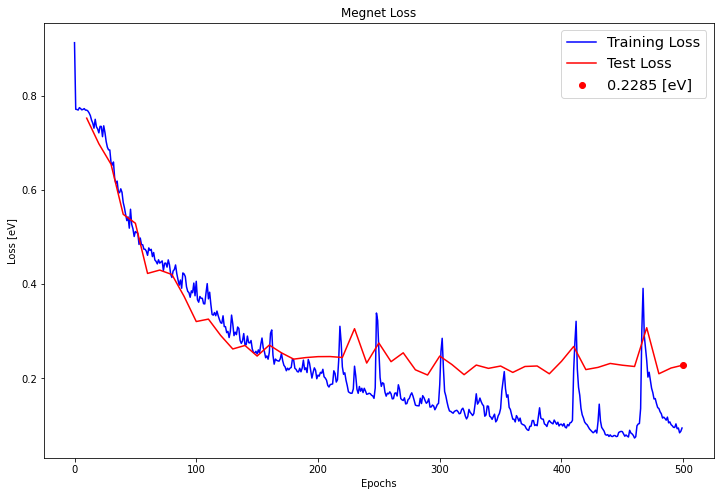

In [37]:
#Plot loss vs epochs    
plt.figure(figsize=(12,8))
plt.plot(np.arange(trainlossall.shape[0]),trainlossall,label='Training Loss',c='blue')
plt.plot(np.arange(epostep,epo+epostep,epostep),testlossall,label='Test Loss',c='red')
plt.scatter([trainlossall.shape[0]],[mae_valid],label="{0:0.4f} ".format(mae_valid)+"["+data_unit +"]",c='red')
plt.xlabel('Epochs')
plt.ylabel('Loss ' + "["+data_unit +"]")
plt.title('Megnet Loss')
plt.legend(loc='upper right',fontsize='x-large')
plt.savefig('megnet_loss.png')
plt.show()

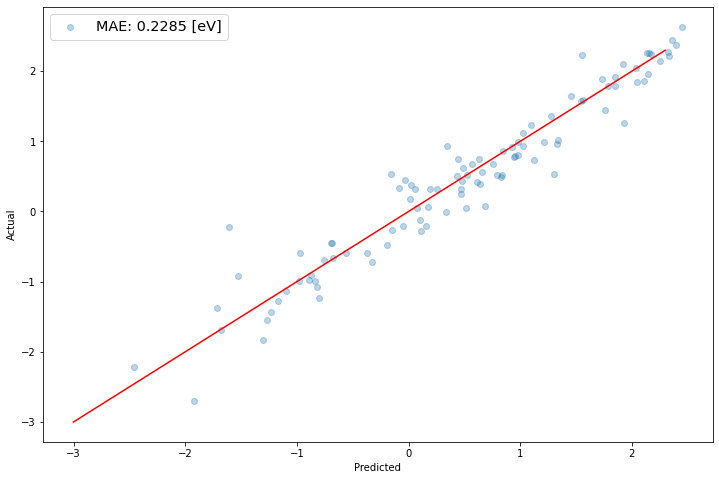

In [38]:
#Predicted vs Actual    
preds = model.predict(xval)
plt.figure(figsize=(12,8))
plt.scatter(preds+y_mean, yval+y_mean, alpha=0.3,label="MAE: {0:0.4f} ".format(mae_valid)+"["+data_unit +"]")
plt.plot(np.arange(np.amin(yval), np.amax(yval),0.05), np.arange(np.amin(yval), np.amax(yval),0.05), color='red')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.legend(loc='upper left',fontsize='x-large')
plt.savefig('megnet_predict.png')
plt.show()